<a href="https://colab.research.google.com/github/cdarbelaez/SolarForecastingElecEngUdeA/blob/main/MODELOS%20SINTONIZADOS/Ramdon_Search__LSTM_Univariable_Array_Standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM NN UNIVARIABLE STANDARD**

---


> En este notebook se realiza la implementación de la red neuronal mencionada: 

*   Se parte del preprocesamiento y análisis de los datos que **NO** está incluido en este script.
*   Luego se procede a cargar y escalar el dataset previamente procesado.
*   Se preparan en ventanas y se separan en set de entrenamiento y validación.
*   Luego se implementa el modelo de aprendizaje automatico con una arquitectura e hiperparametros previamente establecidos.
*   Por último se validan los resultados y se obtienen las métricas de error.

> La diferencia principal de este modelo con los demás LSTM es que se utiliza para escalar los datos la función de sklearn `StandardScaler()` y una sola variable de entrada al modelo que es la GHI.


---

**BASE DE DATOS:** KENYA





In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU



---
# 1.   **SE IMPORTAN LAS BIBLIOTECAS NECESARIAS**

---


In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  Importamos las librerias necesarias para todo el script: 

1.   **Matplotlib** para realizar las gráficas
2.   **Pandas** para procesar la base de datos
3.   **Numpy** para convertir la base de datos en arreglos numéricos
4.   **Os** para acceder a los archivos mediante rutas de almacenamiento
5.   **Seaborn** para realizar análisis gráficos a los datos mediante análisis estadisticos
6.   **Drive** se utiliza para acceder a las carpetas de datos del drive de un correo asociado
7.   **Tensorflow** es la librería mediante la cual se generan los modelos de redes neuronales



In [ ]:
import keras_tuner as kt
from kerastuner import *
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from google.colab import drive 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6) #Definimos el tamaño para las figuras de matplotlib
mpl.rcParams['axes.grid'] = False



---


# 2.   **SE CARGA EL DATASET PREVIAMENTE PROCESADO**

---




En la siguiente celda de codigo se llama una función de google colab mediante la cual se accede a la carpeta de drive, luego se define la ruta de acceso a la base de datos previamente procesados para la realización del modelo y se procesa mediante la librería `Pandas`:

In [ ]:
#ruta= 'https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv'
ruta='https://raw.githubusercontent.com/cdarbelaez/SolarForecastingElecEngUdeA/main/DATABASES/KENYA_LIMPIO.csv'
data = pd.read_csv(ruta,encoding='utf-8') # Se hace la respectiva lectura, no se añade encabezado o indice, por lo que pondrá por defecto la numeracion
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  data.set_index('datetime', inplace=True)
else:
  data.set_index('time', inplace=True) # Establecemos cual será el indice del dataframe
data.head(2) # Se muestran las 5 primeras filas del dataframe

,dhi_pyr,ghi_pyr_1,ghi_pyr_2,air_temperature,relative_humidity,barometric_pressure,precipitation,wind_speed,wind_from_direction,gti_clean,gti_soil,gti_monthly,sensor_cleaning,Hour
time,,,,,,,,,,,,,,
2019-12-12 00:00:00,0.0,0.0,0.0,22.72500,99.003998,948.445923,0.0,1.073283,169.845993,0.0,0.0,0.0,0.0,0
2019-12-12 00:15:00,0.0,0.0,0.0,22.58083,98.758003,948.415283,0.0,0.727417,204.165405,0.0,0.0,0.0,0.0,0




---


# 3. **SE SELECCIONAN LOS DATOS A UTILIZAR PARA EL ENTRENAMIENTO DEL MODELO**


---



In [ ]:
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  features_considered = ['GHI']# Definimos las columnas que se van a utilizar para el entrenamiento del modelo
  features = data[features_considered].loc['2010-04-07 00:00:00':] # Creamos un dataframe con solo estos datos
else:
  features_considered = ['ghi_pyr_1']
  features = data[features_considered] # Creamos un dataframe con solo estos datos
features.head() #Se muestran los 5 primeros datos

,ghi_pyr_1
time,
2019-12-12 00:00:00,0.0
2019-12-12 00:15:00,0.0
2019-12-12 00:30:00,0.0
2019-12-12 00:45:00,0.0
2019-12-12 01:00:00,0.0


Graficamos todos los datos con el fin de apreciar de manera general su comportamiento a lo largo del tiempo con la función plot asociada a la librería `Pandas`.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3cdb05710>],
      dtype=object)

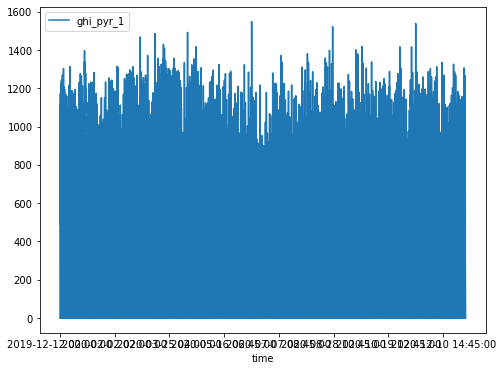

In [ ]:
features.plot(subplots=True) # Graficamos las columnas de datos para observar su comportamiento

Se convierte el conjunto de datos en un arreglo de `numpy` definiendo la cantidad de datos que se van a utilizar para el proceso y luego se estandarizan con la función StandardScaler de la librería sklearn:


In [ ]:
TRAIN_SPLIT = int(len(features)*0.8//1) #Definimos la cantidad de datos que se van a usar para el entrenamiento del modelo
dataset = features.values # Convertimos el dataframe en un arreglo de numpy



---


3_1. **ESCALAMIENTO DE LOS DATOS**


---


In [ ]:
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)




---


# 4.   **SE DEFINE LA FUNCIÓN QUE SE UTILIZA PARA LA PARTICIÓN DE LOS DATOS EN VENTANAS**

--- 

In [ ]:
#---------------------------------------
#CONFIGURACIÓN DE LAS VENTANAS DE DATOS#
#---------------------------------------
DATASPLIT = 0.8                        #
Num_datos_entrada = 96                 #
Num_datos_salida = 96                  #
#---------------------------------------

def ventanas(dataset,xsize,ysize,split,validation= False):
  #dataset: Es un array de numpy obtenido a partir del dataframe de pandas, en este están contenidos todos los datos que se utilizarán
  #split: porcentaje del dataset a utilizar
  #xsize: Número entero, determina el tamaño de la ventana de caracteristicas (Entradas del modelo)
  #ysize: Número entero, determina el tamaño de la ventana de etiquetas (Salidas del modelo)
  #validation: Si es True, toma el porcentaje restante de los datos como set, de lo contrario toma el porcentaje indicado

  if validation!=True: #Se generan los índices para tomar los días exactos para el set de entrenamiento
    indexin=int(0)
    indexf=int((((len(dataset)*split)//xsize)*xsize))
  else: #Se generan los índices para tomar los días exactos para el set de validación
    indexin=int((((len(dataset)*split)//xsize)*xsize))
    indexf=int(len(dataset))
  n=0 # Indexador
  x=[] # Lista vacia donde estarán contenidas las ventanas de datos de entrada (Caracteristicas)
  y=[] # Lista vacia donde estarán contenidas las ventanas de datos de salida (Etiquetas)
  
  for i in range(int(((indexf-indexin)/ysize)-1)): #Este ciclo se repite el número de veces como ventanas habrán en un arreglo de datos
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # indexf=6, indexin=0, xsize=2, ysize=2
                                                   # range= (3-1) = 2  <------ Ya que se obtendrán 3 ventanas de datos
                                                   # Al resultado se le resta uno para considerar que la ultima ventana tambien contenga datos en "y"
                                                   
    x.append(dataset[n+indexin:n+indexin+xsize].T) #Se agrega a la lista la ventana de datos utilizando la idexación 
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # Primera iteración:
                                                   #  x=[[1,2]]
                                                   # Segunda iteración:
                                                   #  x=[[1,2],[3,4]]

    y.append(dataset[n+indexin+xsize:n+indexin+xsize+ysize].T[0])
                                                   # Siguiendo el ejemplo anterior
                                                   #  y=[[3,4]]
                                                   # Segunda iteración:
                                                   #  y=[[3,4],[5,6]]
    
                                                   # Siguiento el ejemplo, los las ventanas listas para entrar al modelo quedan de la siguiente manera
                                                   # x = [[1,2],[3,4]]
                                                   # y = [[3,4],[5,6]]

    n+=ysize # Se suma al indexador el tamaño de la ventana
    
  return np.array(x),np.array(y)

x_train1, y_train1= ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT)
x_val1,y_val1=ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT, validation=True)


In [ ]:
print(x_train1.shape, y_train1.shape)

(307, 1, 96) (307, 96)





---


# 5.   **FUNCIÓN PARA VISUALIZAR LOS RESULTADOS OBTENIDOS**


---



La siguiente de función se utiliza para generar gráficos a partir de una ventana de tiempo como las que se definieron anteriormente, esta se utilizará para mostrar:

*   La ventana de tiempo utilizada para la predicción
*   El valor real de los datos futuros tomado del set de validación
*   El valor de las predicciones que arroja la red neuronal



In [ ]:
def create_time_steps(length): # Función que crea un array en un rango determinado por el tamaño de la ventana de datos
    return list(range(-length, 0))

# history: Un arreglo con la ventana de datos usada para la predicción
# true_future: Arreglo con los datos conocidos que deberia arrojar la predicción 
# prediction: Arreglo con las predicciones obtenidas

def multi_step_plot(history, true_future, prediction): 
    plt.figure(figsize=(12, 6)) # Se define el tamaño de la figura
    num_in = create_time_steps(len(history)) #Tamaño de la curva de datos pasados
    num_out = len(true_future) # Tamaño de la curva de datos futuros
    plt.plot(num_in, history, label='History') # Graficamos datos pasados
    plt.plot(np.arange(num_out)/STEP, (true_future), 'y--',
           label='True Future') #Graficamos datos furutos
    if prediction.any(): # Si se ingresan datos sobre las predicciones
        plt.plot(np.arange(num_out)/STEP, (prediction), 'r--', #Grafica tambien las predicciones
                 label='Predicted Future')
    plt.legend(loc='upper left') # Ajustes de la grafica
    plt.grid()
    plt.show() # Se muestra la grafica

---
 # 6. **CREACIÓN Y ENTRENAMIENTO DEL MODELO**
 ---

**LSTM**: estas redes resuelven el problema de las redes recurrentes convencionales, ya que estas tienen como característica principal que la información puede persistir introduciendo bucles en el diagrama de la red, por lo que, básicamente, pueden recordar estados previos y utilizar esta información para decidir cuál será el siguiente.

En las siguientes celdas se va a definir el modelo de ML que se utilizará para realizar las predicciones buscadas, este modelo consta de una capa de entrada, y dos capas intermedias de neuronas tipo LSTM, con una respectiva función de activación.

![RedNeuronalArtificial.png](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/1024px-LSTM_Cell.svg.png)

Fig 1. [Arquitectura de la red LSTM](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/LSTM_Cell.svg/1024px-LSTM_Cell.svg.png)



La cantidad de neuronas ajustada de forma manual para maximizar su precisión de entrenamiento y una capa de salida con n neuronas con n datos de predicción buscados.

Además se compila el modelo y dentro de dicha compilación estan incluidas configuraciónes, donde las configuraciones son:

*   **optimizer**: Optimizador utilizado Adam
*   **loss**: Métrica utilizada para determinar las perdidas del modelo es mean_absolute_error
*   **metrics**: Guarda los valores de las metricas en cada epoca de entrenamiento

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    error_max = 0.05
    if(logs.get('loss')< error_max):
      print(f"\nReached less than {error_max} losses so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=70)

In [ ]:
batch_size=1

**PASOS PARA LA OPTIMIZACIÓN DE LOS HIPERPARAMETROS**:

1) Se crea una funcion que se encarga de la creación del modelo("buil_model"), en la que se definen los parametros que se van a optimizar y los rangos entre los cuales el optimizador realizara los diferentes ajustes.

Se utiliza "hp" el cual es un objeto que el sintonizador usa internamete en la función de creación del modelo en el cual se especifica el rango de valores que se van a probar para optimizar el hiperparametro. Ademas, se utilizan tres tipos para establecer estos rango, el primero es "hp.Int()" se utiliza para generan un rango en el cual se tienen numeros enteros, el segundo es "hp.Floating ()" el cual se usa para establecer un rango con numeros decimales,por ultimo, "hp.Choice()" se utiliza para proporcionar valores especificos y funciones que se utilizarán para realizar las optimizaciones.

In [ ]:
def build_model(hp):
  activacion = hp.Choice('Activacion', ['tanh', 'relu', 'sigmoid', 'softmax', 'gelu', 'elu'])                                
  neuronas_c1 = hp.Int('Units1', min_value = 20, max_value = 200, step = 20)
  neuronas_c2 = hp.Int('Units2', min_value = 20, max_value = 200, step = 20)
  dropout = hp.Float('Dropout', min_value = 0, max_value = 0.3, step = 0.05)
  model = tf.keras.models.Sequential([  
      tf.keras.layers.LSTM(neuronas_c1, activation = activacion, stateful= True, batch_input_shape= (batch_size, x_train1.shape[1], x_train1.shape[2]),  dropout=dropout, return_sequences=True),
      tf.keras.layers.LSTM(neuronas_c2, activation= activacion, stateful= True, dropout=dropout),
      tf.keras.layers.Dense(96)
  ])
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
  hp_optimizers = hp.Choice('Optimizer', values = ['adam', 'adamax','nadam','RMSprop','SGD'])
  if hp_optimizers == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  if hp_optimizers == 'adamax':
    opt = tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  if hp_optimizers == 'nadam':
    opt = tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate)
  if hp_optimizers == 'RMSprop':
    opt = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
  if hp_optimizers == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  model.compile(optimizer=opt, loss='mean_absolute_error',metrics=["accuracy"])
  return model

2) Se crea una instancia del sintonizador la cual en este caso usara "RandomSearch". Una forma de encontrar los parametros optimos es probar todas las combinaciones posibles de los parametros disponibles, mejor conocido como busqueda de cuadricula, pero al hacer esto el numero de combinaciones aumenta exponencialmente con el aumento de los hiperparametros. Por lo tanto, el "RandomSearch" ayuda a explorar más espacio de hiperparámetros en menos tiempo si se compara con la busqueda en cuadricula.

Esta funcion "RandomSearch" tiene como parametro a la función de construccion o "build_model", tambien se define como onjetivo del sintonizador la precisión de la validación o "val_accuracy" que es el objetivo principal cuando se ajustan los hiperparámetros. Tambien, se utiliza el "max_trail" el cual es el número de combinaciones a probar y encontrar el mejor entre ellos. Otro utilizado es "executions_per_trial " el cual le dice al sintonizador la cantidad de veces que se ejecuta una sola combinación.

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = 'loss',
    max_trials= 200,
    executions_per_trial = 1,
    directory = 'my_dir3',
    overwrite=True
)

3) Se ejecuta el ajuste usando "tuner.search()"

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
Activacion (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu', 'sigmoid', 'softmax', 'gelu', 'elu'], 'ordered': False}
Units1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': None}
Units2 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': None}
Dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07], 'ordered': True}
Optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adamax', 'nadam', 'RMSprop', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(x_train1, y_train1, epochs = 200, validation_data=(x_val1, y_val1))

Trial 200 Complete [00h 00m 17s]
loss: 0.1550273895263672

Best loss So Far: 0.15128645300865173
Total elapsed time: 00h 55m 02s
INFO:tensorflow:Oracle triggered exit


4) Se obtienen los hiperparámetros y modelos óptimos del sintonizador.

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

{'Activacion': 'softmax', 'Units1': 40, 'Units2': 40, 'Dropout': 0.0, 'learning_rate': 0.001, 'Optimizer': 'adam'}


In [ ]:
n_best_models = tuner.get_best_models(num_models =2)
print(n_best_models[0].summary())
print(n_best_models[1].summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 40)                21920     
                                                                 
 lstm_1 (LSTM)               (1, 40)                   12960     
                                                                 
 dense (Dense)               (1, 96)                   3936      
                                                                 
Total params: 38,816
Trainable params: 38,816
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 140)               132720    
                                                                 
 lstm_1 (LSTM)             

In [ ]:
model = tuner.hypermodel.build(best_hyperparameters)

In [ ]:
history = model.fit(x_train1, y_train1, epochs=300, verbose=1, validation_data=(x_val1, y_val1), batch_size=batch_size, shuffle=False, callbacks=[early_stopping_cb, callbacks])

Epoch 1/300
307/307 [==============================] - 2s 3ms/step - loss: 0.6583 - accuracy: 0.0326 - val_loss: 0.4231 - val_accuracy: 0.0658
Epoch 2/300
307/307 [==============================] - 1s 2ms/step - loss: 0.2646 - accuracy: 0.0977 - val_loss: 0.1249 - val_accuracy: 0.1579
Epoch 3/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1585 - accuracy: 0.1629 - val_loss: 0.1057 - val_accuracy: 0.0526
Epoch 4/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1537 - accuracy: 0.1596 - val_loss: 0.1059 - val_accuracy: 0.0526
Epoch 5/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1533 - accuracy: 0.1596 - val_loss: 0.1062 - val_accuracy: 0.0526
Epoch 6/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1533 - accuracy: 0.1596 - val_loss: 0.1067 - val_accuracy: 0.0526
Epoch 7/300
307/307 [==============================] - 1s 2ms/step - loss: 0.1532 - accuracy: 0.1596 - val_loss: 0.1069 - val_accuracy: 0.0526

Epoch 176/300
581/581 [==============================] - 4s 7ms/step - loss: 0.1018 - val_loss: 0.1268


---


# 7. **RESULTADOS Y ANÁLISIS** 📃


---


En esta sección del codigo se observarán y analizarán los resultados obtenidos realizando predicciones con el modelo que generamos.  ✌

---
**EVALUACIÓN DEL MODELO**

---

In [ ]:
model.evaluate(x_val1, y_val1),model.evaluate(x_train1, y_train1)

10/10 [==============================] - 0s 2ms/step - loss: 0.1546 - accuracy: 0.1596


([0.10776494443416595, 0.05263157933950424],
 [0.15463358163833618, 0.1596091240644455])

**CURVA DE ENTRENAMIENTO DEL MODELO**

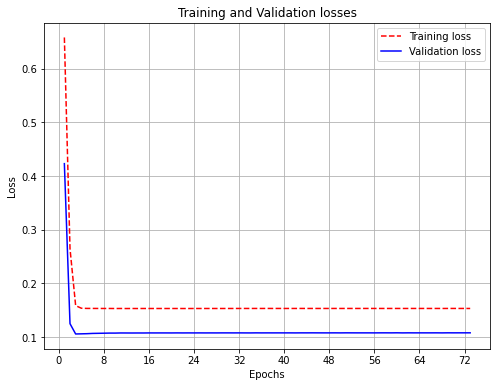

<Figure size 576x432 with 0 Axes>

In [ ]:
def metricas(history):
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]


  epochs   = range(1,len(loss)+1,1)
  plt.plot ( epochs,     loss, 'r--', label='Training loss' )
  plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.title ('Training and Validation losses'   )
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.grid(True)

  plt.legend()
  plt.figure() 

metricas(history)

**CÁLCULO DE LAS MÉTRICAS DE ERROR**

In [ ]:
n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_train1)):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
tMAPE =np.array(MAPE).mean()
tMAE =np.array(MAE).mean()
tRMSE =np.array(RMSE).mean()

n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_val1)):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5


  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
  
vMAPE =np.array(MAPE).mean()
vMAE =np.array(MAE).mean()
vRMSE =np.array(RMSE).mean()

In [ ]:
print("Nota aclaratoria: El valor del MAPE se obtuvo sin considerar")
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(tMAE,tMAPE*100,tRMSE))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(vMAE,vMAPE*100,vRMSE))
print("----------------------------------")


Nota aclaratoria: El valor del MAPE se obtuvo sin considerar
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  63.7092     31.9550    112.5952
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  44.4752     16.5642     82.6000
----------------------------------



----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
   40.4231     13.9251     78.5699
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  40.5472     16.6566     77.4171
----------------------------------

**GRÁFICOS CON LOS DATOS DE ENTRENAMIENTO**

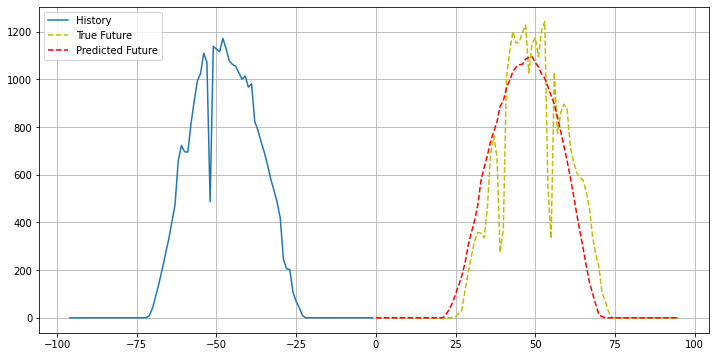

El MAPE para un horizonte de 24h es: 21.99248249008299 %


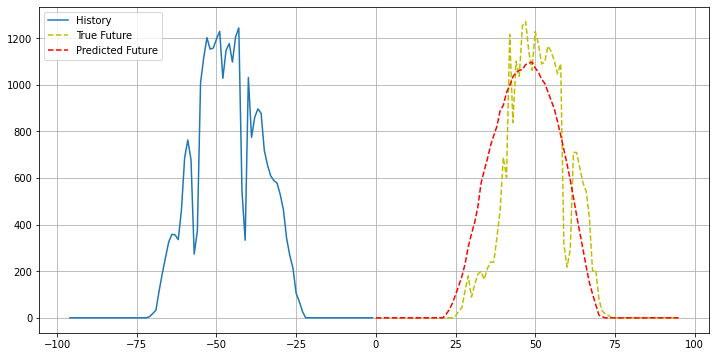

El MAPE para un horizonte de 24h es: 27.793217580816542 %


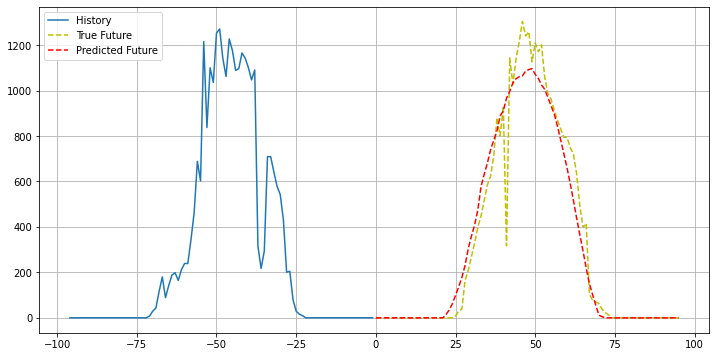

El MAPE para un horizonte de 24h es: 13.143431485173595 %


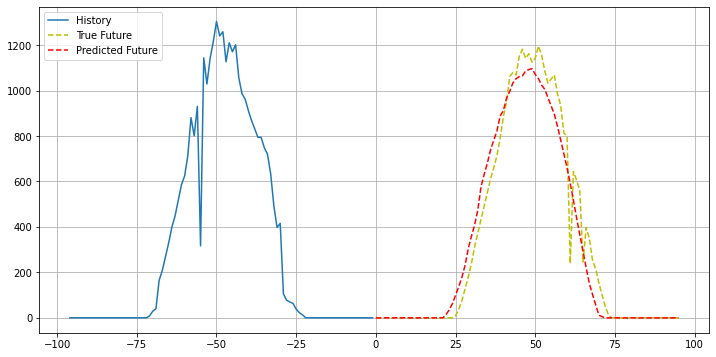

El MAPE para un horizonte de 24h es: 13.965897816489933 %


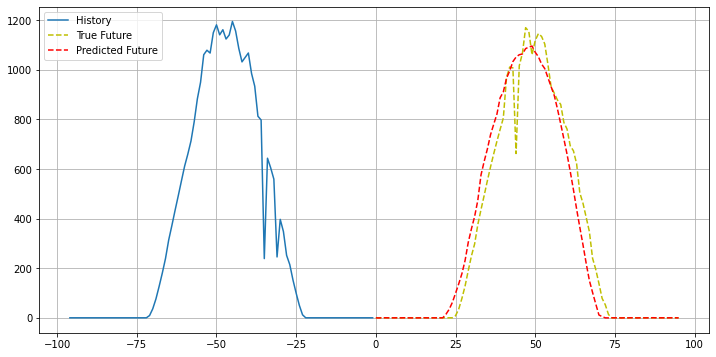

El MAPE para un horizonte de 24h es: 12.575807169815963 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  mae= (abs(y-yt)).mean()
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1

**GRÁFICOS CON LOS DATOS DE VALIDACIÓN**

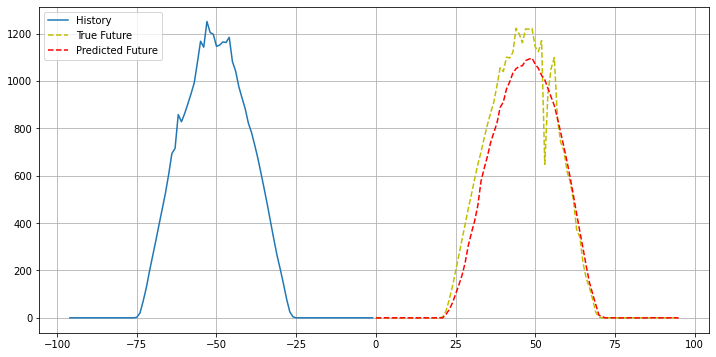

El MAPE para un horizonte de 24h es: 12.553262745570093 %


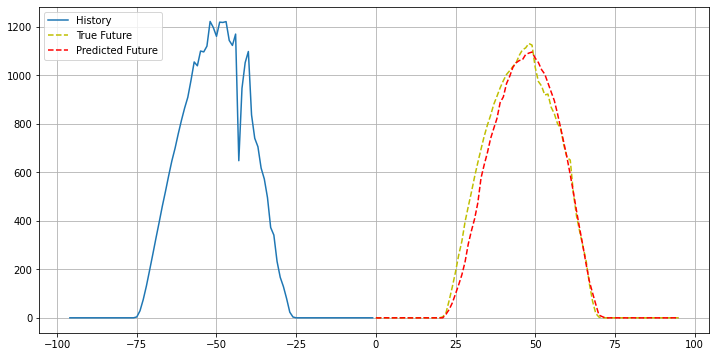

El MAPE para un horizonte de 24h es: 7.519843112432765 %


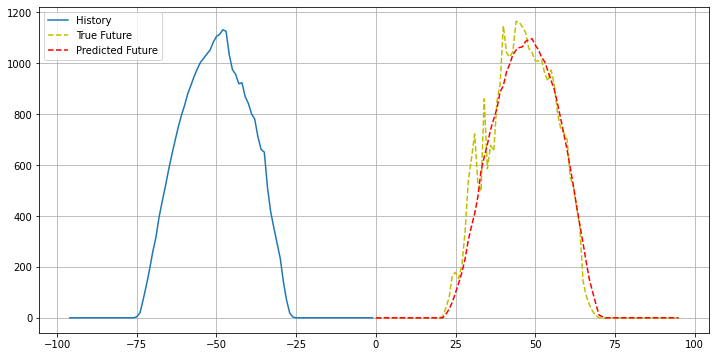

El MAPE para un horizonte de 24h es: 9.24425916653237 %


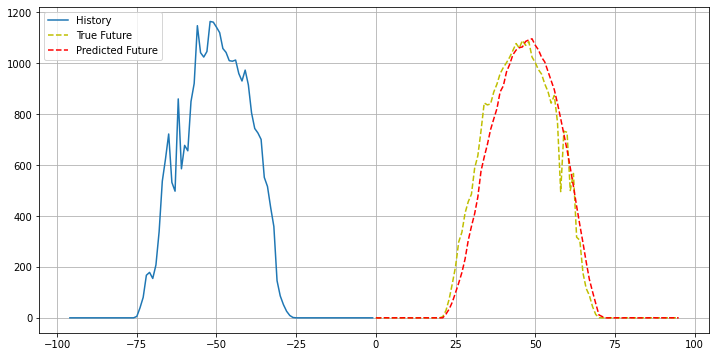

El MAPE para un horizonte de 24h es: 10.646055258799274 %


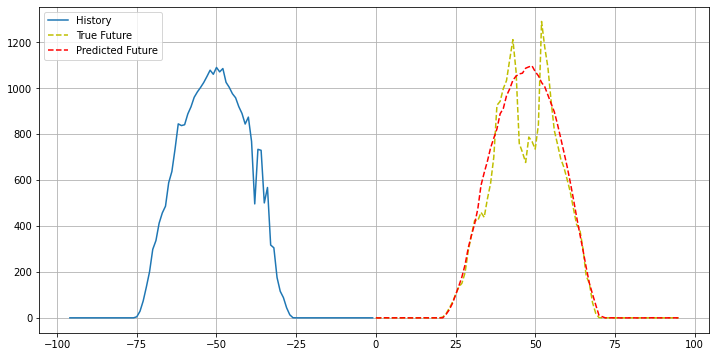

El MAPE para un horizonte de 24h es: 12.5676296993712 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  mae= (abs(y-yt)).mean()
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1